## Analisi di convessità e duration delle obbligazioni
Il notebook, dato l'ISIN di un bond, calcola parametri come yield, duration e convexity recuperando alcune info di base dal sito simpletoolsforinvestors.eu

*  https://ba-odegaard.no/gcc_prog/recipes/recipes.pdf


*  https://github.com/jeffrey-liang/Financial-Numerical-Recipes-in-Python/tree/master

*  https://medium.com/@add.mailme/bond-maths-and-its-implementation-in-python-d952dd585f5d

*  https://github.com/andreranza/pca-yield-curve-modelling

*  https://github.com/shatteringlass/bitscraper/

*  https://bond-pricing.readthedocs.io/en/latest/

<p>
<a href="https://colab.research.google.com/github/jumping2000/Quants/blob/master/portfolio_anlysis/Bond_pricing.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://github.com/jumping2000/Quants/blob/main/portfolio_anlysis/Bond_pricing.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>
</p>

# Scarico Dati obbligazioni

In [ ]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
from requests.exceptions import HTTPError, Timeout, RequestException
import sys

In [ ]:
########################################
market =  'francia' #
isin =  'FR0014001NN8'
########################################
url_base = 'https://www.simpletoolsforinvestors.eu/'
url = f'https://www.simpletoolsforinvestors.eu/monitor_info.php?monitor={market}&yieldtype=G&timescale=DUR'

In [ ]:
class BondInfo:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key.replace(" ", "_").lower(), value)

def fetch_webpage(url, timeout=10):
    try:
        # Send a GET request to the specified URL with a timeout
        response = requests.get(url, timeout=timeout)
        # Check if the request was successful
        response.raise_for_status()  # Raises HTTPError for bad responses (4xx and 5xx)
        # Parse the content with BeautifulSoup
        soup = BeautifulSoup(response.content, 'html.parser')
        return soup
    except HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")  # Specific HTTP errors
    except Timeout:
        print("The request timed out")
    except RequestException as err:
        print(f"An error occurred: {err}")  # Catch-all for requests exceptions
    except Exception as e:
        print(f"An unexpected error occurred: {e}", file=sys.stderr)
    return None

def extract_data(soup):
    if soup is None:
        print("No data to extract because soup is None")
        return
    try:
        # Iterate over each row in the tbody
        for row in soup.find_all('tr')[1:]:  # Skipping the header row
            # Find the first <td> tag (Codice ISIN)
            codice_isin = row.find('td') #.text.strip()
            codice_isin_bond = codice_isin.text.strip()
            if codice_isin_bond == isin:
                bond_url = codice_isin.find_next_sibling('td').find('a')['href']
                bond_url = url_base + bond_url
                soup_bond = fetch_webpage(bond_url)
                table_bond = soup_bond.find_all('table', class_='table-sm table-bordered table-striped')
                tbody = table_bond[0].find('tbody')
                rows = tbody.find_all('tr')
                fields = [None] * len(labels)  # Initialize a list to store the extracted values
                for row in rows:
                    label = row.find_all('td')[0].text.strip()
                    if label in labels:
                        fields[labels.index(label)] = row.find_all('td')[1].text.strip()
                tbody = table_bond[1].find('tbody')
                rows = tbody.find_all('tr')
                for row in rows:
                    label = row.find_all('td')[0].text.strip()
                    if label in labels:
                        fields[labels.index(label)] = row.find_all('td')[1].text.strip()
                #divisa, lotto, d_emissione, p_emissione, d_rimborso, p_rimborso, tasso, periodicità = fields[2:10]
                dictionary = dict(zip(labels, fields))
                dictionary = {'ISIN': codice_isin_bond, **dictionary}
                return dictionary
    except AttributeError as e:
        print(f"Attribute error while parsing: {e}", file=sys.stderr)
    except Exception as e:
        print(f"An unexpected error occurred while extracting data: {e}", file=sys.stderr)

# Etichette da cercare
labels = [
    "Data di regolamento",
    "Prezzo di regolamento",
    "Divisa di emissione",
    "Lotto Minimo",
    "Data emissione",
    "Prezzo emissione",
    "Data rimborso",
    "Prezzo rimborso",
    "Tasso cedolare",
    "Periodicità cedola",
    "Tassazione applicata"
]

dizionario = None
soup = fetch_webpage(url)
table_bonds = soup.find('table', id='YieldTable')
dizionario = extract_data(table_bonds)

# Print the key-value pairs in one print statement
#print(', '.join([f"{key}: {value}\n" for key, value in dizionario.items()]))
print('################################################################################')
print(''.join([f"{key}: {value}\n" for key, value in dizionario.items()]))
print('################################################################################')
# Create an instance of BondInfo
bond = BondInfo(**dizionario)

################################################################################
ISIN: FR0014001NN8
Data di regolamento: 11/10/2024
Prezzo di regolamento: 36,22
Divisa di emissione: EUR
Lotto Minimo: 1.000
Data emissione: 25/05/2020
Prezzo emissione: 95,895
Data rimborso: 25/05/2072
Prezzo rimborso: 100,000
Tasso cedolare: 0,500%
Periodicità cedola: Annuale
Tassazione applicata: 12,50%

################################################################################


In [ ]:
from string import printable
# Accessing properties
date_format = "%d/%m/%Y"
# Convert strings to datetime objects
d1 = datetime.strptime(bond.data_di_regolamento, date_format)
d2 = datetime.strptime(bond.data_rimborso, date_format)
# Calculate the difference in days
delta_days = (d2 - d1).days
# Convert the difference to years, approximating to the first decimal
delta_years = round(delta_days / 365.25, 1)  # 365.25 accounts for leap years
# Parametri dell'obbligazione
C = float(bond.tasso_cedolare.replace('%', '').replace(',', '.'))    # Cedola annuale
M = float(bond.prezzo_rimborso.replace(',', '.'))  # Valore nominale di rimborso
T = round(delta_years)    # Maturità / Anni fino alla scadenza
P_current = float(bond.prezzo_di_regolamento.replace(',', '.')) #37.61 prezzo
tax = float(bond.tassazione_applicata.replace('%', '').replace(',', '.'))/100
print('\n################################ FROM SIMPLETOOLS #################################')
print(f'ISIN:{bond.isin} Maturità in anni:{delta_years} Cedola:{C} Prezzo rimborso:{M} Quotazione:{P_current} Tassazione:{tax}' )


################################ FROM SIMPLETOOLS #################################
ISIN:FR0014001NN8 Maturità in anni:47.6 Cedola:0.5 Prezzo rimborso:100.0 Quotazione:36.22 Tassazione:0.125


## Chapter 4: Bond pricing with a flat term structure

In this section we use the present value framework of the previous chapter to price bonds and other fixed income securities. What distinguishes bonds is that the future payments are set when the security is issued. The simplest, and most typical bond, is a fixed interest, constant maturity bond with no default risk. There is however a large number of alternative contractual features of bonds. The bond could for example ba an annuity bond, paying a fixed amount each period. For such a bond the principal amount outstanding is paid gradually during the life of the bond. The interest rate the bond pays need not be fixed, it could be a floating rate, the interest rate paid could be a function of some market rate. Many bonds are issued by corporations, and in such cases there is a risk that the company issued the bond defaults, and the bond does not pay the complete promised amount. Another thing that makes bond pricing difficult in practice, is that interest rates tend to change over time.


We start by assuming that all the promised payments are certain. Then the bond current price $B_0$ is found as the present value of these payments. The first step of pricing is to use the terms of the bond to find the promised payments. We start by considering a fixed  interest bond with no default risk. Such bonds are typically bonds issued by governments. The bond is a promise to pay a face value $F$ at the maturity date $T$ periods from now. Each period the bond pays a fixed percentage amount of the face value as coupon C. The cash flows from the bond thus look as follows.

In general a bond price is found as the present value

$$B_0=d_1C_1+d_2C_2+\cdot\cdot\cdot+d_TC_T=\sum_{t=1}^{T}d_tC_t$$

where $d_t$ is the discount factor, or the time 0 price of a payment of 1 at time $t$. To fully specify the
problem it is necessary to find all discount factors $d_t$. In this chapter we will work with a specially simple
specifiction of the term structure, namely that it is flat, and specified by the interest rate $r$.

### 4.1 Flat term structure with discrete, annual compounding
This is the simplest possible specification of a term structure,

$$d_t = \Big(\frac{1}{1+r}\Big)^t=\frac{1}{(1+r)^t}$$

### 4.1.1 Bond Price
The current bond price $(B_0)$ is the present value of the cash flows from the bond

$$B_0=\sum_{t=1}^{T}\Bigg(\frac{1}{(1+r)^t}\Bigg)C_t=\sum_{t=1}^{T}\frac{C_t}{(1+r)^t}$$

If we continue with the example of a standard fixed interest bond, where $C_t = C$ when $t < T$ and
$CT = C + F$,

#### Example
A 3 year bond with a face value of $100 makes annual coupon payments of 10%. The current interest rate
(with annual compounding) is 9%.

1. Determine the current bond price.

The current bond price: $B_0=\frac{10}{(1+0.09)^1}+\frac{10}{(1+0.09)^2}+\frac{110}{(1+0.09)^3}=102.531$

### 4.1.1 Yield to maturity
Since bonds are issued in terms of interest rate, it is also useful to find an interest rate number that
summarizes the terms of the bond. The obvious way of doing that is asking the question: What is the
internal rate of return on the investment of buying the bond now and keeping the bond to maturity?
The answer to that question is the yield to maturity of a bond. The yield to maturity is the interest
rate that makes the present value of the future coupon payments equal to the current bond price, that
is, for a known price $B_0$, the yield is the solution y to the equation

$$B_0\sum_{t=1}^{T}\frac{C_t}{(1+y)^t}$$

This calculation therefore has the same qualifications as discussed earlier calculating IRR, it supposes
reinvestment of coupon at the bond yield (the IRR).

There is much less likelihood we’ll have technical problems with multiple solutions when doing this yield
estimation for bonds, since the structure of cash flows is such that there exist only one solution to the
equation. The algorithm for finding a bonds yield to maturity shown in **Code 4.2** is thus simple
bisection. We know that the bond yield is above zero and set zero as a lower bound on the bond yield.
We then find an upper bound on the yield by increasing the interest rate until the bond price with this
interest rate is negative. We then bisect the interval between the upper and lower until we are “close
enough.” **Code 4.2** implements this idea.

### 4.1.3 Duration

When holding a bond one would like to know how sensitive the value of the bond is to changes in
economic environment. The most relevent piece of the economic environment is the current interest
rate. An important component of such calculation is the duration of a bond. The duration of a bond
should be interpreted as the weighted average maturity of the bond, and is calculated as

$$Duration = \frac{\sum_{t}t\frac{C_t}{(1+r)^t}}{Bond\ Price'}$$

where $C_t$ is the cash flow in period $t$, and $r$ the interest rate. Using the bond price calculated in equation 4.1 we calculate duration as

$$D=\frac{\sum_{t}\frac{tC_t}{(1+r)^t}}{\sum_{t}\frac{C_t}{((1+r)^t}}$$

An alternative approach to calculating duration is calculate the yield to maturity $y$ for the bond, and
use that in estimating the bond price. This is called *Macaulay Duration*. First one calculates $y$, the
yield to maturity, from

$$Bond\ price = \sum_{t=1}^{T}\frac{C_t}{(1+y)^t}$$

and then use this y in the duration calculation:

$$ Macaulay\ duration=\frac{\sum_{t}\frac{tC_t}{(1+r)^t}}{\sum_{t}\frac{C_t}{((1+r)^t}}$$

Note though, that in the present case, with a flat term structure, these should produce the same number.
If the bond is priced correctly, the yield to maturity must equal the current interest rate. If $r = y$ the
two calculations in equations (4.4) and (4.5) obviously produces the same number.

#### Example
A 3 year bond with a face value of $100 makes annual coupon payments of 10%. The current interest rate
(with annual compounding) is 9%.

1. Determine the current bond price.
2. Calculate the duration using the current interest rate.
3. Calculate the duration using the MaCaulay definition.

Need to calculate the following:

The current bond price: $B_0=\frac{10}{(1+0.09)^1}+\frac{10}{(1+0.09)^2}+\frac{110}{(1+0.09)^3}=102.531$

The bond's duration: $D=\frac{1}{102.531}\Big(\frac{1.10}{1.09}+\frac{2.10}{1.09^2}+\frac{3.110}{1.09^3}\Big)=2.74$

### 4.1.4 Measuring bond sensitivity to interest rate changes

Now, the reason for why we say that we can measure the sensitivity of a bond price using duration. To
a first approximation, $\Delta B_0$, the change in the bond price for a small change in the interest rate $\Delta r$, can
be calculated

$$\frac{\Delta B_0}{B_0} \approx - \frac{D}{1+r} \Delta r$$

where $D$ is the bond’s duration. For simplicity one often calculates the term in front of the $\Delta y$ in the above, $\frac{D}{1+y}$ directly and terms it the bond’s *modified duration*.

$$Modified\ Duration=D^*=\frac{D}{1+r}$$

The sensitivity calculation is then
$$D^*=\frac{D}{1+y}$$

The modified duration measures the angle of the tangent at the current bond yield. Approximating
the change in bond price with duration is thus only a first order approximation. To improve on this
approximation we also need to account for the curvature in the relationship between bond price and
interest rate. To quantify this curvature we calculate the *convexity* of a bond.

$$Convexity=Cx=\frac{1}{B_0}\frac{1}{((1+r)^2}\sum_{t=1}^{T}(t+t^2)\frac{C_t}{(1+r)^t}$$



This calculation is implemented in **Code 4.6**. To improve on the estimate of how the bond price change when the interest rates changes you will then calculate

$$\frac{\Delta B_0}{B_0}\approx-D^*\Delta y + \frac{1}{2}Cx(\Delta y)^2$$

### 4.2 Continously compounded interest

Some important differences is worth pointing out. When using continously compounded interest, one
does not need the concept of *modified duration*. In the continously compounded case one uses the
calculated duration directly to approximate bond changes, as seen in the formulas describing the approximation of bond price changes. Note also the difference in the *convexity* calculation, one does not divide by $(1 + y)^2$ in the continously compounded formula, as was done in the discrete case.

The term structure is flat, and compounding is continous. Consider two definitions of duration, the “usual” definition $D = \frac{1}{B_0}\sum_{i}t_iC_{t_i}e^{-rt}$ and the Macaulay defintion: $D=\frac{1}{b_0}\sum_{i}t_iC_{t_i}e^{-yt_i}$, where $B_0$ is the current bond price, $C_{t_i}$ is the coupon payment at date $t_i$, $r$ is the current interest rate and $y$ is the bond’s yield to maturity.

################################################################################
ISIN:FR0014001NN8 Valuta:EUR Maturità in anni:47.6 Cedola:0.5 Prezzo rimborso:100.0 Quotazione:36.22 Tassazione:0.125
Yield to Maturity (Gross): 0.0305
Yield to Maturity (Net): 0.0266
Macaulay duration: 37.9459
Modified duration: 36.8244
Convexity: 1628.3336
################################################################################


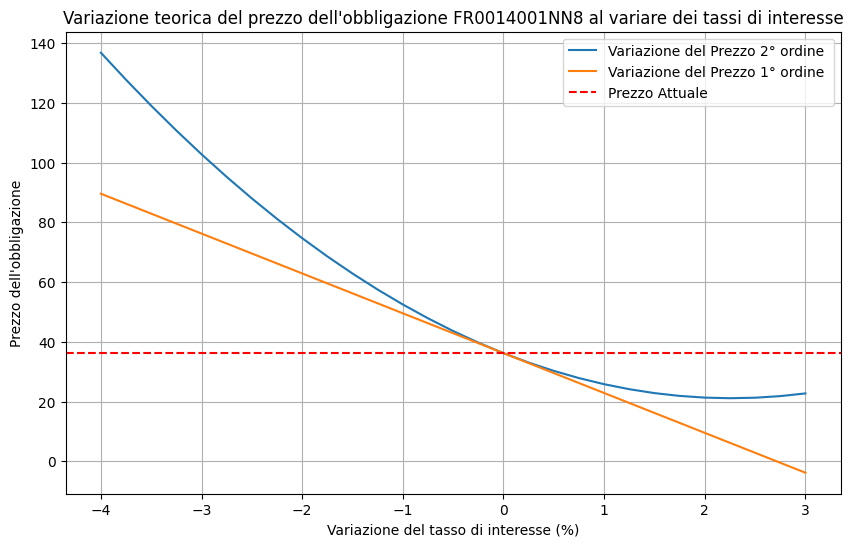

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parametri dell'obbligazione
# C = 0.5    # Cedola annuale
# M = 100  # Valore nominale di rimborso
# T = 47   # Maturità / Anni fino alla scadenza
# P_current = 37.5 #37.61 prezzo
#y_current = 0.031  # Rendimento a scadenza (YTM)

# Calcolo del prezzo attuale dell'obbligazione
def bond_price(C, M, T, y):
    """
    Calcola il prezzo dell'obbligazione dato il rendimento a scadenza (YTM).
    C : Cedola annuale
    M : Valore nominale di rimborso
    T : Maturità in anni
    y : Rendimento a scadenza (YTM)
    """
    price = sum([C / (1 + y)**t for t in range(1, T + 1)]) + M / (1 + y)**T
    return price

def bond_price_derivative(C, M, T, y):
    """
    Calcola la derivata del prezzo dell'obbligazione rispetto al rendimento a scadenza (YTM).
    """
    derivative = sum([-t * C / (1 + y)**(t + 1) for t in range(1, T + 1)]) - T * M / (1 + y)**(T + 1)
    return derivative

def bond_ytm(C, M, T, current_price, initial_guess=0.05, tol=1e-6, max_iter=100):
    """
    Calcola il rendimento a scadenza (YTM) usando il metodo di Newton-Raphson.
    current_price : Prezzo corrente dell'obbligazione
    initial_guess : Valore iniziale per il YTM (default: 0.05)
    tol : Tolleranza per la convergenza (default: 1e-6)
    max_iter : Numero massimo di iterazioni (default: 100)
    """
    ytm = initial_guess
    for _ in range(max_iter):
        price = bond_price(C, M, T, ytm)
        derivative = bond_price_derivative(C, M, T, ytm)
        new_ytm = ytm - (price - current_price) / derivative
        if abs(new_ytm - ytm) < tol:
            return new_ytm
        ytm = new_ytm
    raise ValueError("Il calcolo del YTM non è convergente")

#P_current = bond_price(C, M, T, ytm)
#print('bond price = {:.3f}'.format(P_current))
ytm = bond_ytm(C, M, T, P_current)
print('################################################################################')
print(f'ISIN:{bond.isin} Valuta:{bond.divisa_di_emissione} Maturità in anni:{delta_years} Cedola:{C} Prezzo rimborso:{M} Quotazione:{P_current} Tassazione:{tax}' )
print(f"Yield to Maturity (Gross): {ytm:.4f}")
print(f"Yield to Maturity (Net): {ytm*(1-tax):.4f}")

# Calcolo della durata Macaulay
def macaulay_duration(C, M, T, y):
    weighted_sum = sum([t * C / (1 + y)**t for t in range(1, T + 1)]) + T * M / (1 + y)**T
    price = bond_price(C, M, T, y)
    duration = weighted_sum / price
    return duration

D = macaulay_duration(C, M, T, ytm)
print(f'Macaulay duration: {D:.4f}')
D_mod = D / (1 + ytm)
print(f'Modified duration: {D_mod:.4f}')

# Calcolo della convessità
def convexity(C, M, T, y):
    convexity_sum = sum([t * (t + 1) * C / (1 + y)**(t + 2) for t in range(1, T + 1)]) + T * (T + 1) * M / (1 + y)**(T + 2)
    price = bond_price(C, M, T, y)
    convexity = convexity_sum / price
    return convexity

Convexity = convexity(C, M, T, ytm)
print(f'Convexity: {Convexity:.4f}')
print('################################################################################')

# Calcolo della variazione di prezzo al variare dei tassi di interesse
delta_y = np.arange(-0.04, 0.031, 0.0025)  # Variazione dei tassi di interesse, rispetto agli attuali, da -4% a +3%
price_changes = -D_mod * delta_y + 0.5 * Convexity * delta_y**2
price_variations = P_current * (1 + price_changes)
#print(price_variations)
## prezzo senza convessità
price_var_1 = P_current *(1 + -D_mod * delta_y)
#print(price_var_1)

# Grafico
plt.figure(figsize=(10, 6))
plt.plot(delta_y * 100, price_variations, label='Variazione del Prezzo 2° ordine')
plt.plot(delta_y * 100, price_var_1, label='Variazione del Prezzo 1° ordine ')
plt.axhline(y=P_current, color='r', linestyle='--', label='Prezzo Attuale')
plt.xlabel('Variazione del tasso di interesse (%)')
plt.ylabel('Prezzo dell\'obbligazione')
plt.title(f'Variazione teorica del prezzo dell\'obbligazione {bond.isin} al variare dei tassi di interesse')
plt.legend()
plt.grid(True)
plt.show()